In [1]:
import torch
from diffusers.utils import load_image
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, DPMSolverMultistepScheduler
from transformers import CLIPVisionModelWithProjection
from controlnet_aux import OpenposeDetector
from IPython.display import display, HTML
import io
import numpy as np
import base64

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


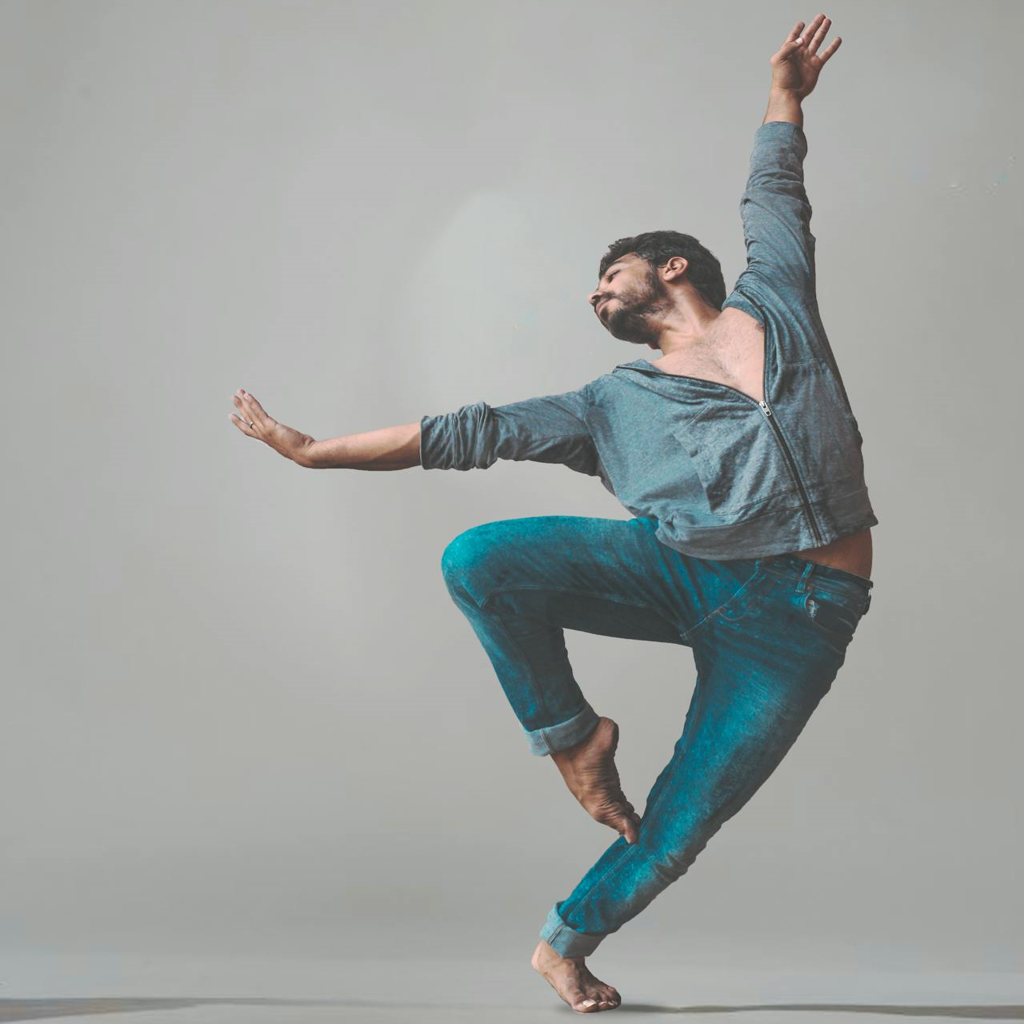

In [2]:
# ポーズ検出前の画像
pose_source_img = load_image("dancing_man.png")
pose_source_img = pose_source_img.resize((1024, 1024))

pose_source_img

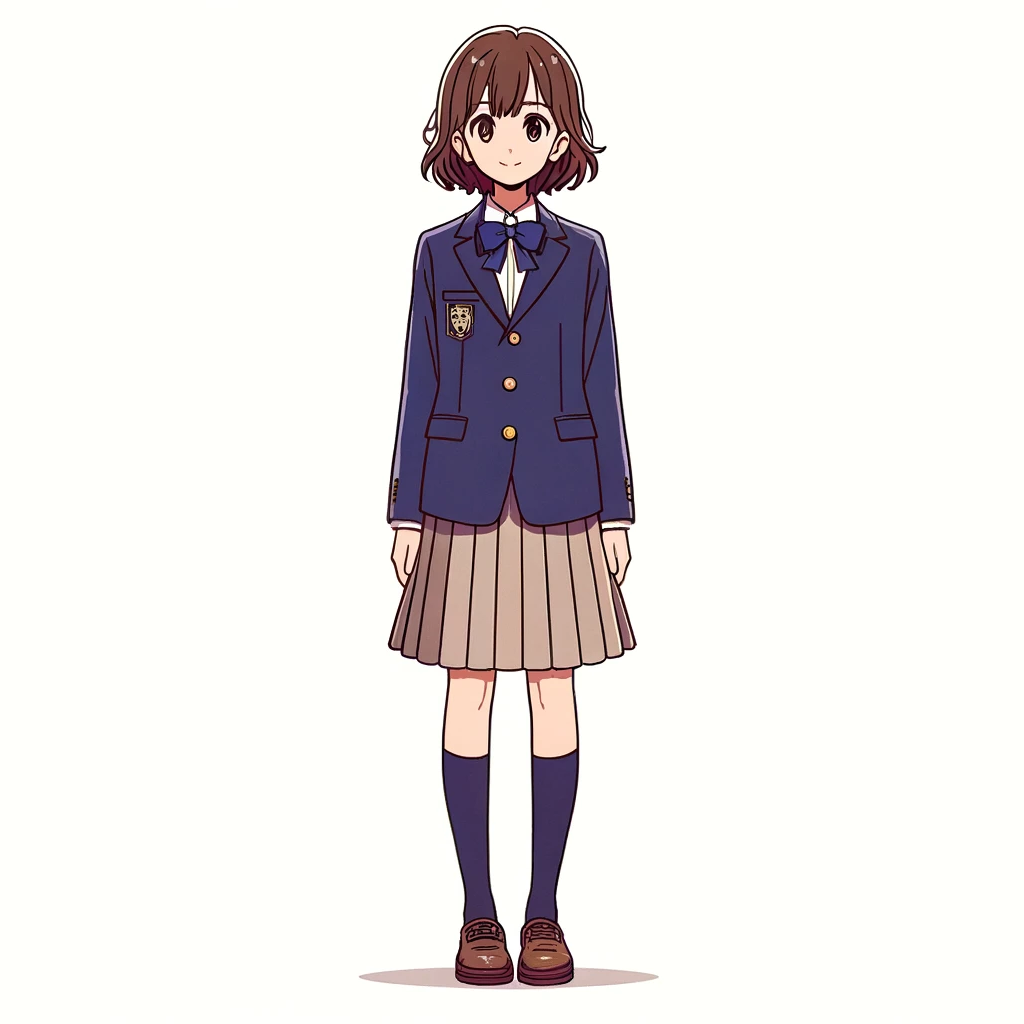

In [3]:
# IP Adapterにいれる画像
ip_adapter_image = load_image("school_girl.png")
ip_adapter_image = ip_adapter_image.resize((1024, 1024))

ip_adapter_image

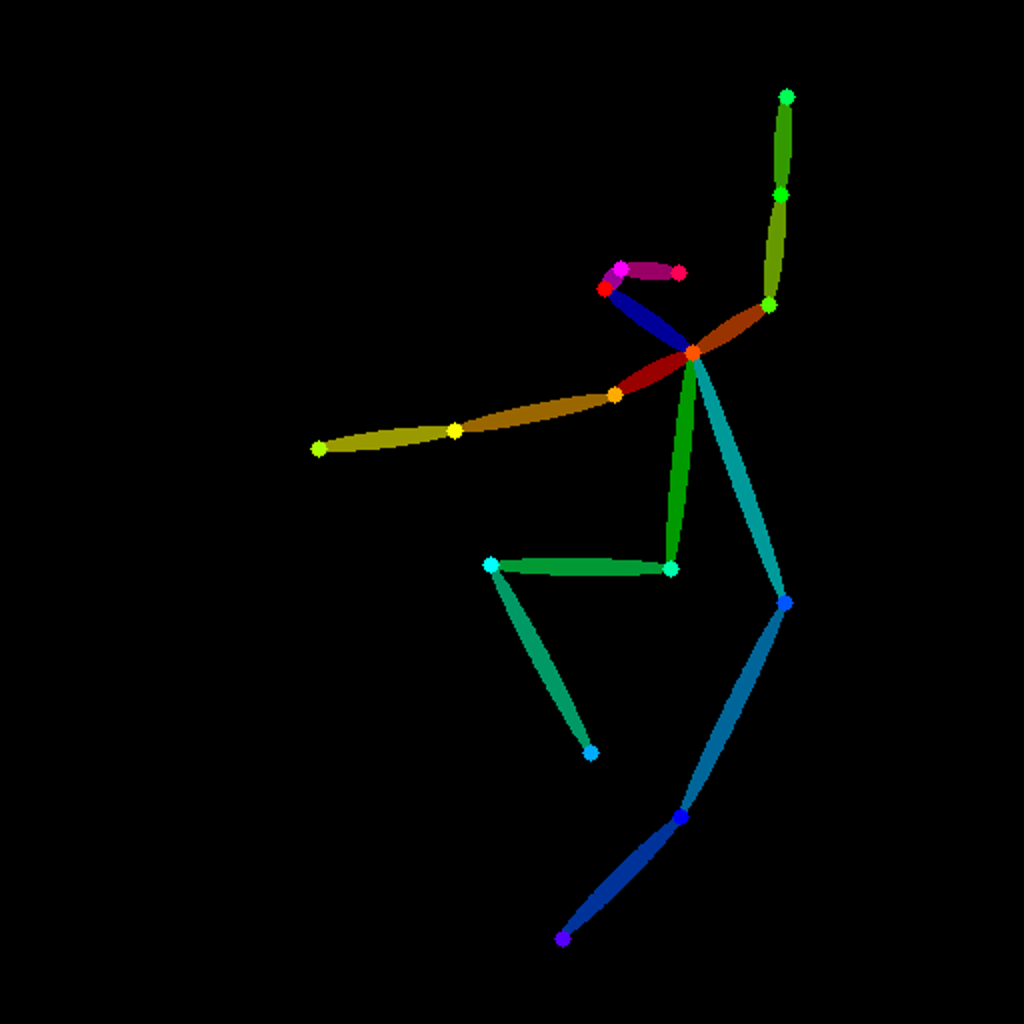

In [4]:
# ポーズ画像の準備
openpose_detector = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
pose_image = openpose_detector(pose_source_img)
pose_image = pose_image.resize((1024, 1024))

pose_image

In [5]:
# ControlNet
controlnet_pose = ControlNetModel.from_pretrained(
    "thibaud/controlnet-openpose-sdxl-1.0",
    torch_dtype=torch.float16
).to("cuda")

# Stable Diffusion Model
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "cagliostrolab/animagine-xl-3.1",
    controlnet=[controlnet_pose],
    torch_dtype=torch.float16
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
# VRAM足りない人向け（オフロードとVAEのTilingで14.1GBギリギリ）
pipe.enable_model_cpu_offload()
pipe.enable_vae_tiling()

In [7]:
# Scheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config,
    algorithm_type="sde-dpmsolver++",
    use_karras_sigmas=True
)

In [8]:
# 画像をバイトデータに変換するヘルパー関数
def pil_to_base64(image):
    with io.BytesIO() as output:
        image.save(output, format="PNG")
        data = output.getvalue()
    return base64.b64encode(data).decode('utf-8')

# 2x2のHTMLテーブルを作成
def display_images(images):
    html_str = '<table>'
    n = int(np.ceil(np.sqrt(len(images))))
    for i in range(0, len(images), n):
        html_str += '<tr>'
        for j in range(n):
            if i + j < len(images):
                img_data = pil_to_base64(images[i + j])
                html_str += f'<td><img src="data:image/png;base64,{img_data}" style="margin: 10px; height: 512px;"></td>'
        html_str += '</tr>'
    html_str += '</table>'
    return display(HTML(html_str))

## IP Adapter Original

In [9]:
# IP-Adapter
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="sdxl_models",
    weight_name="ip-adapter_sdxl.safetensors"
)

# ImageEncoder (CLIP)
pipe.image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",  
    subfolder="sdxl_models/image_encoder",  # ViT-bigG
    torch_dtype=torch.float16).to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


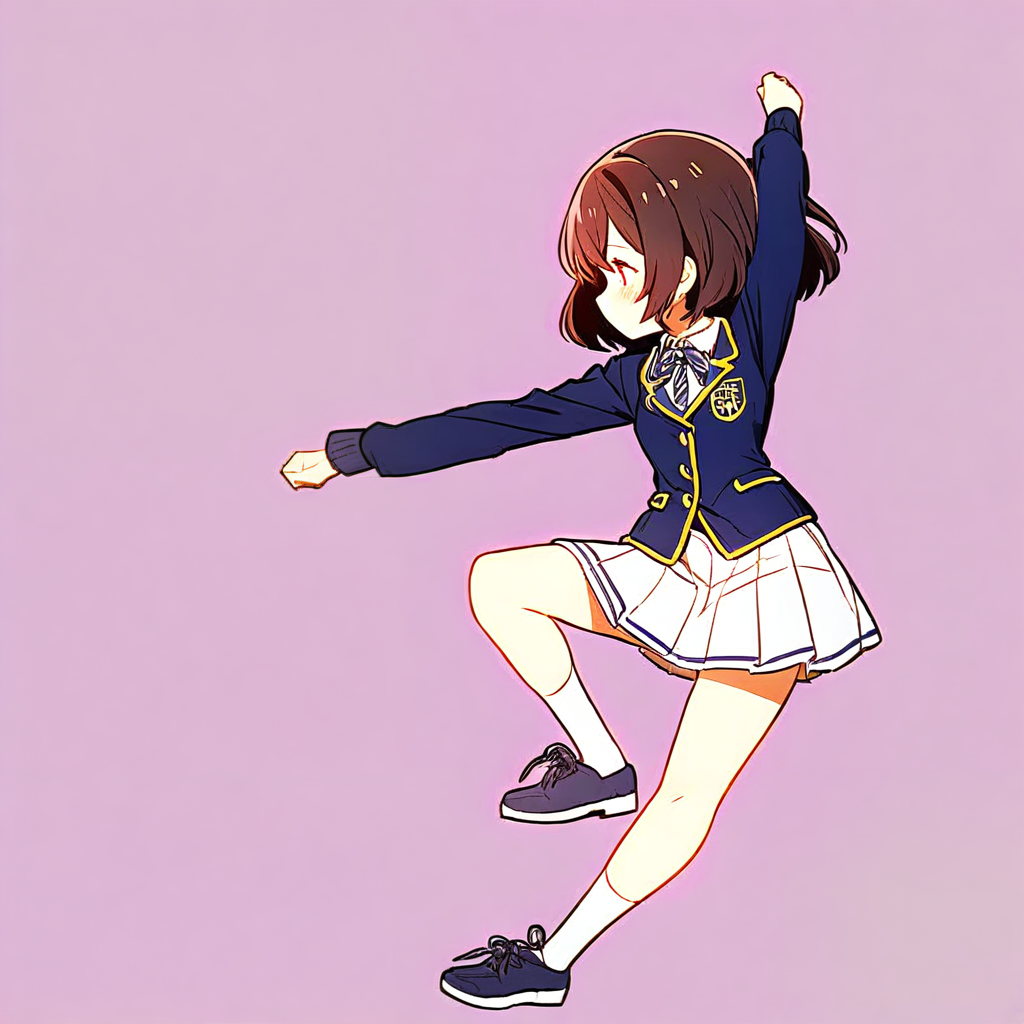
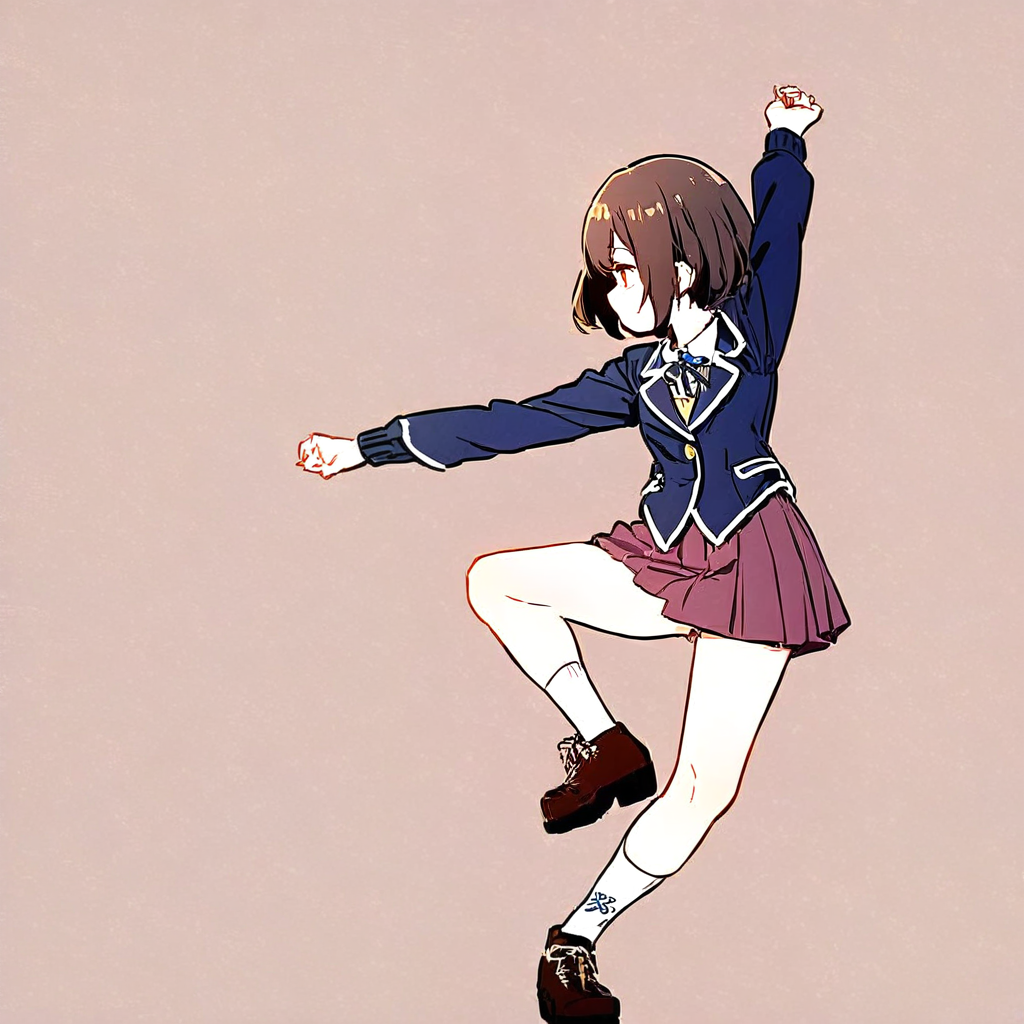
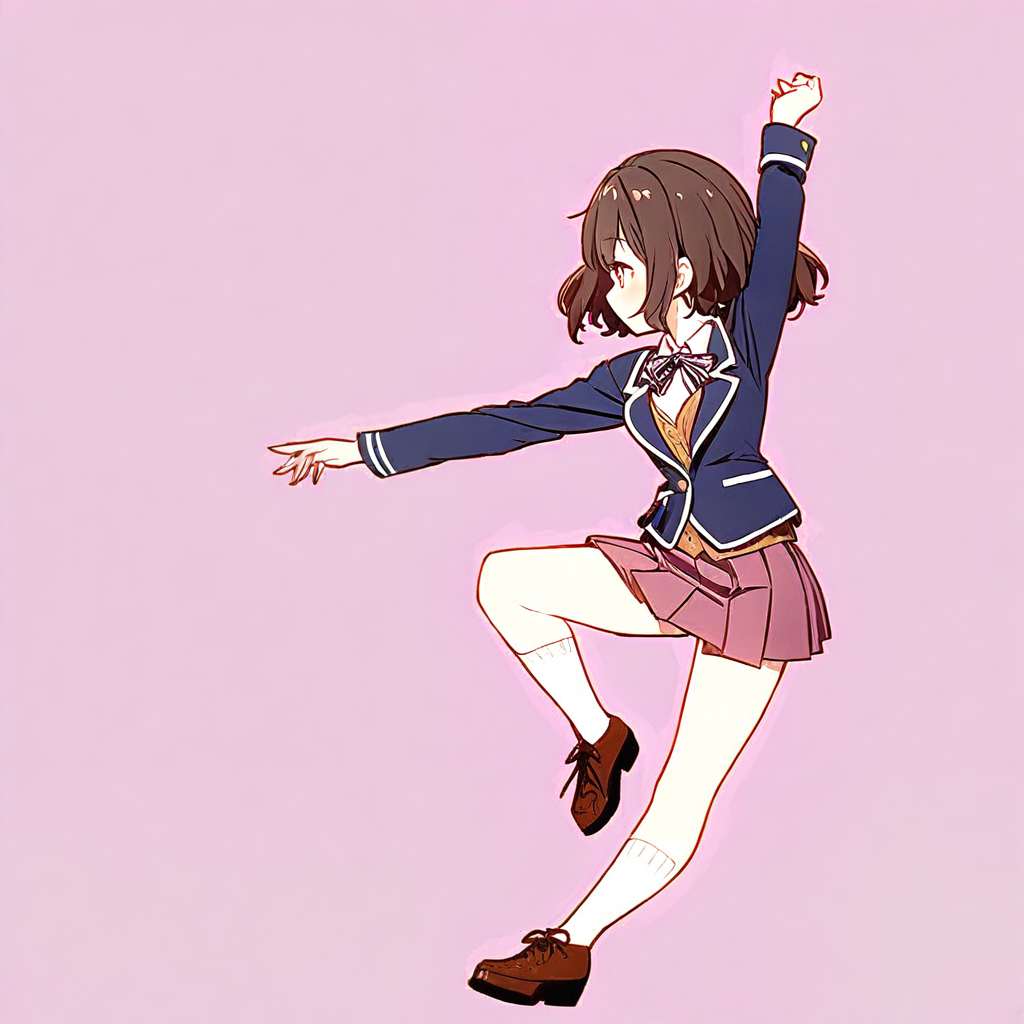
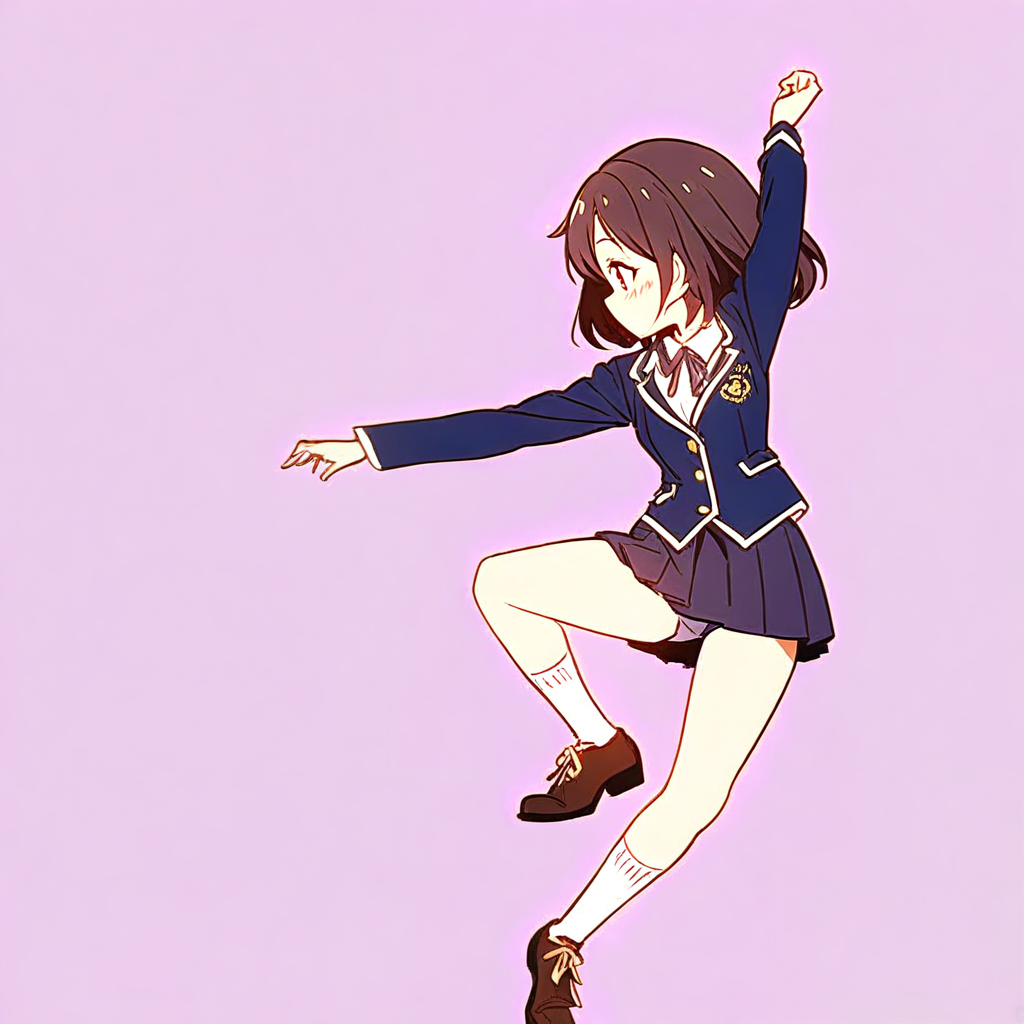

In [10]:
images = []

for i in range(4):
    image = pipe(
        "1girl, dancing, best quality",
        negative_prompt="longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality",
        num_inference_steps=50,
        generator=torch.Generator().manual_seed(i),
        image=[pose_image],
        ip_adapter_image=ip_adapter_image
    ).images[0]
    images.append(image)


display_images(images)

## IP Adapter Plus

In [11]:
# IP-Adapter
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="sdxl_models",
    weight_name="ip-adapter-plus_sdxl_vit-h.safetensors" # ViT-H
)

# Reset CLIP
pipe.image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",  
    subfolder="models/image_encoder",  # ViT-H
    torch_dtype=torch.float16).to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


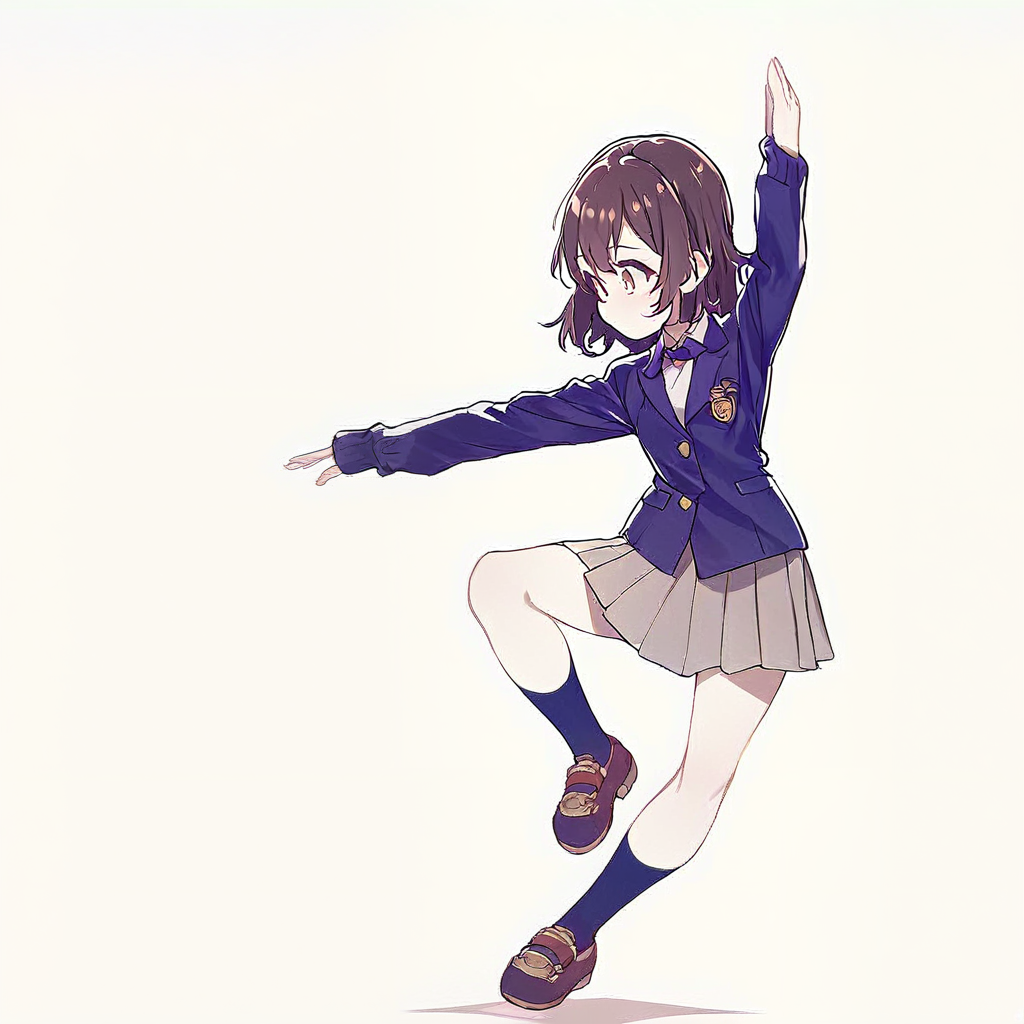
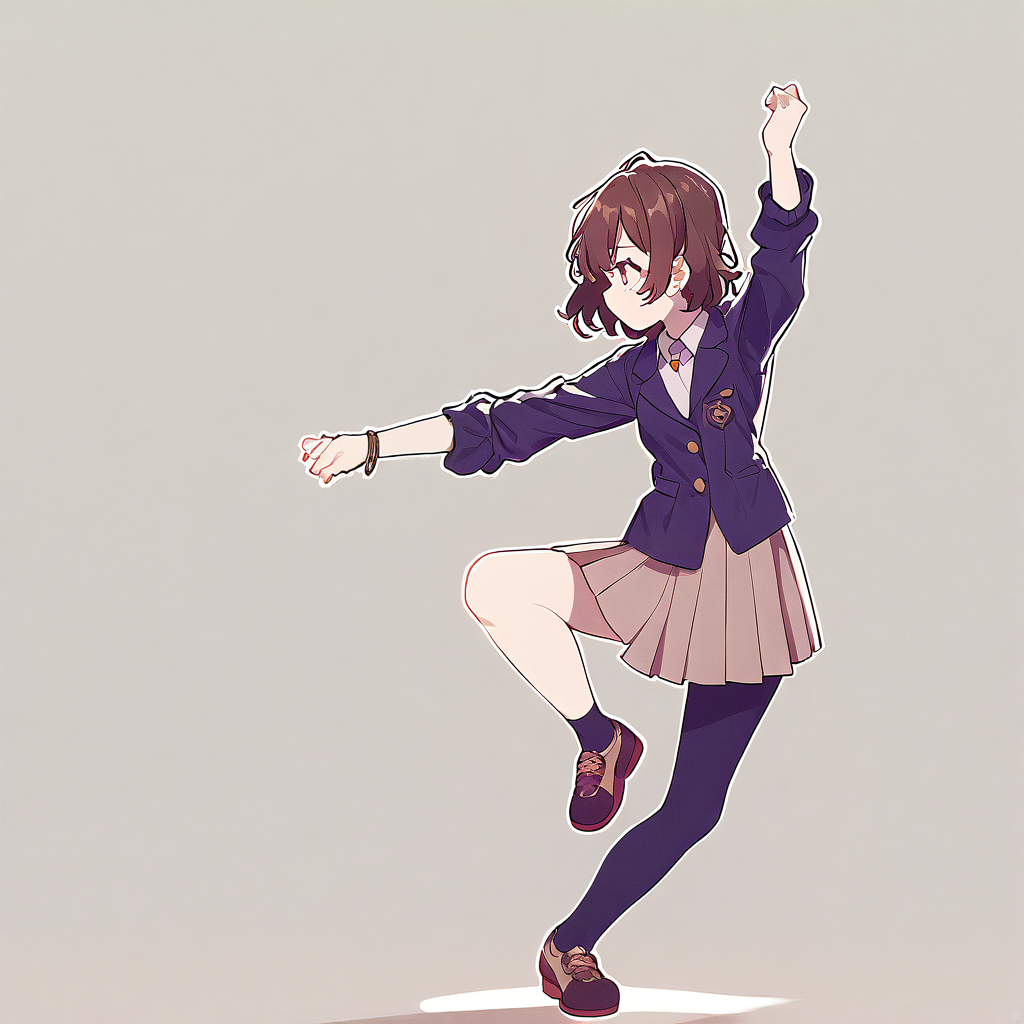
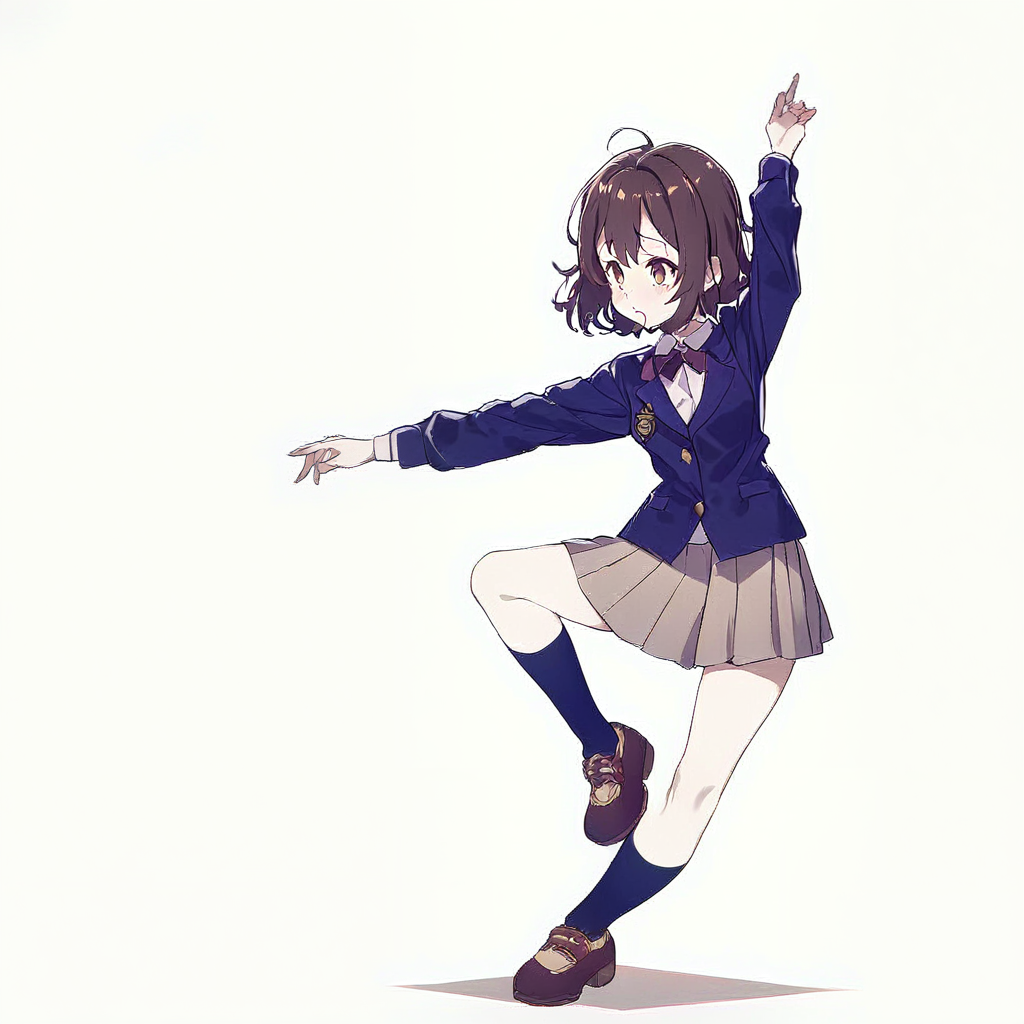
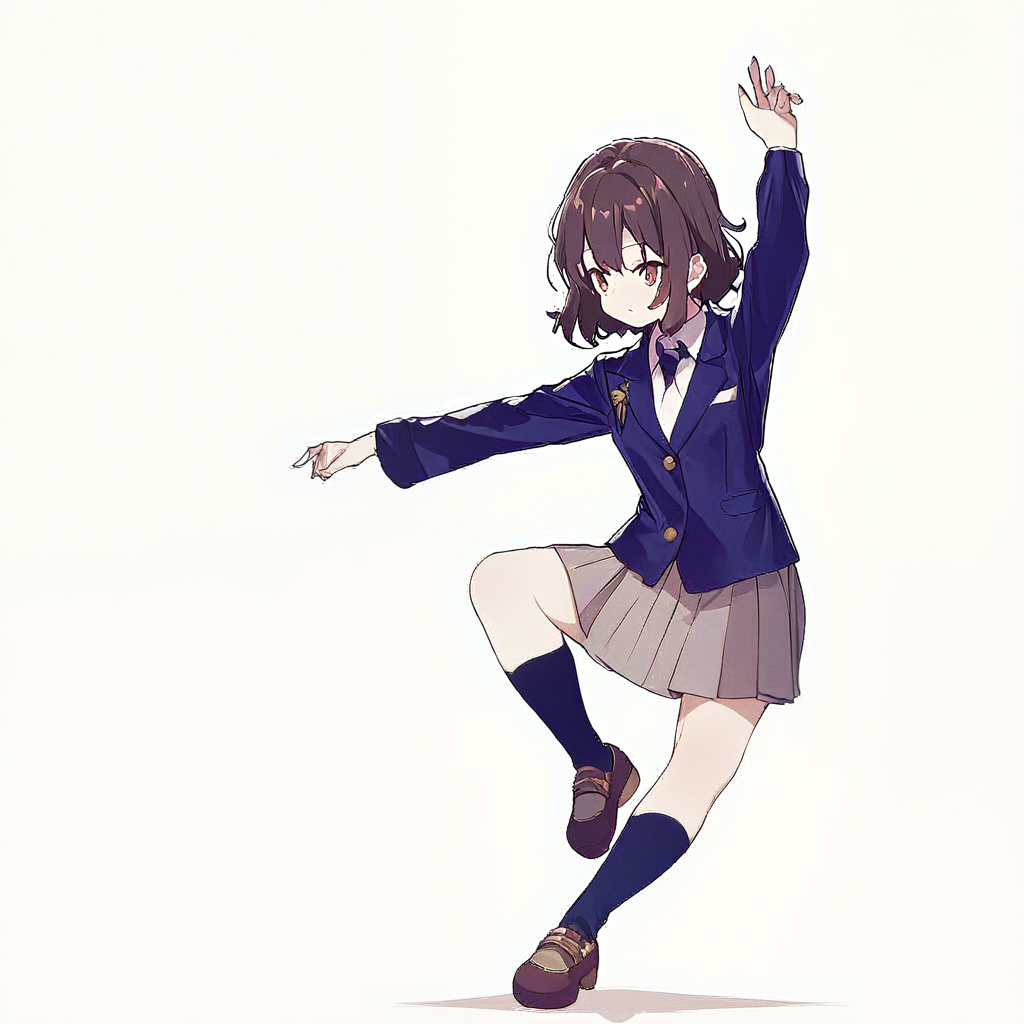

In [13]:
images = []

for i in range(4):
    image = pipe(
        "1girl, dancing, best quality",
        negative_prompt="longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality",
        num_inference_steps=50,
        generator=torch.Generator().manual_seed(i),
        image=[pose_image],
        ip_adapter_image=ip_adapter_image
    ).images[0]
    images.append(image)


display_images(images)

In [14]:
## VRAM14GB程度